<a href="https://colab.research.google.com/github/naga-sk/DataScienceTraining-Assignments/blob/main/AIML/SBWU_Elections_NB_and_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

# Read Data

In [80]:
df = pd.read_csv("https://raw.githubusercontent.com/balaji2v/Inceptez_Batch19/main/sbwu_elections.csv")

In [81]:
df.head()

,Store,Location,State,RTWState,VoteCountDate,VotesYes,VotesNo,VoteTotal,Margin,Result
0,Camp Road Hamburg,"Buffalo, NY",NY,No,12/9/2021,8,12,20,-0.20,No
1,Genessee St,"Buffalo, NY",NY,No,12/9/2021,15,9,24,0.25,Yes
2,Elmwood,"Buffalo, NY",NY,No,12/9/2021,19,8,27,0.41,Yes
3,Power & Baseline Road,"Mesa, AZ",AZ,Yes,2/25/2022,25,3,28,0.79,Yes
4,Sheridan & Bailey,"Buffalo, NY",NY,No,3/9/2022,15,12,27,0.11,Yes


# Making Sense of Data

1.   All `store` names are unique. Will drop this field. 
2.   Secondly, we have the `location` *(city) with state*, `state` and whether it is a `RTWState` *(Right to Work state)*. Of this, we will sanity check the city and state values and then check correlation. If we can arrive at correlation, we can convert them to numeric values and use for prediction
3. `Vote count date` seems irrelevant for now. In the limited data, as the dates are almost continuous, any correlation is supposed to be coincidental and NOT causal - unless we have data about events that happened prior to, or, in those dates, which could have affected the results. We could try converting this to a numeric value and include in the correlation.
4. The `Votes Yes`, `Votes No` and `Margin`, all of these ARE the outcome. If we used these fields to predict results, we will always get 100% results. The idea is to predict the results before we can know the votes. So, we will try to avoid these fields in our forecast. 
5. `Votes Total` is an interesting field. It will not be accurately known in advance to predict outcomes in a production dataset. This values is also an direct outcome of voting which will only be known after the votes are counted which will yield the results. However, we could apply a nominal voter turn out on the whole population of workers who are voting and retain this field for prediction.

In [82]:
# Analysis of objects - Categorical and String data
# Note that store and Location don't have enough variation to draw correlations
# Of this, we will drop the store
# We will later figure out if we want to keep location

df.describe(include='O').T

,count,unique,top,freq
Store,76,76,Camp Road Hamburg,1
Location,76,47,"Eugene, OR",8
State,76,18,NY,17
RTWState,76,2,No,49
VoteCountDate,76,29,5/3/2022,10
Result,76,2,Yes,66


In [83]:
# Analysis of numeric variables - both discrete and continuous
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VotesYes,76.0,13.986842,7.399988,4.00,9.750,12.500,17.0000,46.0
VotesNo,76.0,4.644737,6.202589,0.00,1.000,2.500,7.0000,36.0
VoteTotal,76.0,18.631579,11.282839,5.00,13.000,15.500,21.0000,82.0
Margin,76.0,0.561316,0.393695,-0.31,0.225,0.685,0.8825,1.0


# Preparing Data

In [84]:
# Map the result to discrete numeric values using a label encoder
# Following this approach - No = 0, Yes = 1
from sklearn.preprocessing import LabelEncoder

df.Result = LabelEncoder().fit_transform(df.Result)

df.head()

,Store,Location,State,RTWState,VoteCountDate,VotesYes,VotesNo,VoteTotal,Margin,Result
0,Camp Road Hamburg,"Buffalo, NY",NY,No,12/9/2021,8,12,20,-0.20,0
1,Genessee St,"Buffalo, NY",NY,No,12/9/2021,15,9,24,0.25,1
2,Elmwood,"Buffalo, NY",NY,No,12/9/2021,19,8,27,0.41,1
3,Power & Baseline Road,"Mesa, AZ",AZ,Yes,2/25/2022,25,3,28,0.79,1
4,Sheridan & Bailey,"Buffalo, NY",NY,No,3/9/2022,15,12,27,0.11,1


In [85]:
# As mentioned before, let us drop Store, VoteYes, VoteNo and Margin fields
df = df.drop(["Store","VotesYes","VotesNo","Margin"], axis=1)

df.head()

,Location,State,RTWState,VoteCountDate,VoteTotal,Result
0,"Buffalo, NY",NY,No,12/9/2021,20,0
1,"Buffalo, NY",NY,No,12/9/2021,24,1
2,"Buffalo, NY",NY,No,12/9/2021,27,1
3,"Mesa, AZ",AZ,Yes,2/25/2022,28,1
4,"Buffalo, NY",NY,No,3/9/2022,27,1


In [86]:
# Try to do some basic correlation of state to the results by creating of pivot
# table of RTWState against Result aggregated using mean
rtw_corr = df[["RTWState","Result"]].groupby("RTWState").mean()
rtw_corr

,Result
RTWState,
No,0.897959
Yes,0.814815


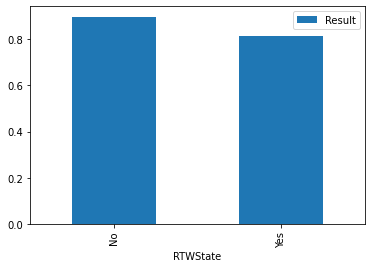

In [87]:
rtw_corr.plot.bar()
# This is NOT evident a strong correlation between RTWState individually against Result

In [88]:
# Try to do some basic correlation of state to the results by creating of pivot
# table of State against Result aggregated using mean
state_corr = df[["State","Result"]].groupby("State").mean()
state_corr

,Result
State,
AZ,1.000000
CO,1.000000
FL,0.571429
GA,1.000000
IL,0.666667
KS,1.000000
MA,1.000000
MD,1.000000
MN,1.000000


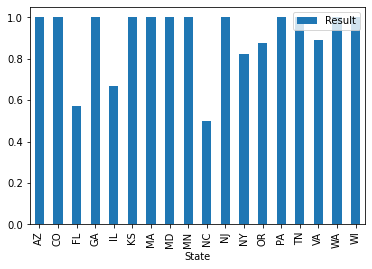

In [89]:
state_corr.plot.bar()
# This is NOT evident a strong correlation between State individually against Result

In [90]:
# Is it possible to check individual correlation of <Location> against <Result>?
# Based on the result below, we can conclude that some meaningful correlation 
# between <Location> against <Result> can be drawn only for 2 locations - 
# Eugene, OR and Buffalo, NY
#
# However, we can retain <Location> in the hope that adding more data to the dataset 
# in the future could reveal better correlation
df.groupby("Location").agg({"Result":"mean", "Location":"count"}).sort_values(by="Result", ascending=False)

,Result,Location
Location,,
"Augusta, GA",1.000000,1
"Massapequa, NY",1.000000,1
"Miami Springs, FL",1.000000,1
"Midlothian, VA",1.000000,1
"Minneapolis, MN",1.000000,1
"New York, NY",1.000000,2
"Oak Creek, WI",1.000000,1
"Olympia, WA",1.000000,1
"Overland Park, KS",1.000000,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       76 non-null     object
 1   State          76 non-null     object
 2   RTWState       76 non-null     object
 3   VoteCountDate  76 non-null     object
 4   VoteTotal      76 non-null     int64 
 5   Result         76 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.7+ KB


In [92]:
# Let us convert the other categorical values into labels
df.Location = LabelEncoder().fit_transform(df.Location)
df.State = LabelEncoder().fit_transform(df.State)
df.RTWState = LabelEncoder().fit_transform(df.RTWState)

df.head()

,Location,State,RTWState,VoteCountDate,VoteTotal,Result
0,6,11,0,12/9/2021,20,0
1,6,11,0,12/9/2021,24,1
2,6,11,0,12/9/2021,27,1
3,23,0,1,2/25/2022,28,1
4,6,11,0,3/9/2022,27,1


In [105]:
# Only value left to convert is the date object. Let us transform this to a 
# discrete value

df['VoteCountDate']= pd.to_datetime(df['VoteCountDate'])

In [106]:
df.head()

,Location,State,RTWState,VoteCountDate,VoteTotal,Result
0,6,11,0,2021-12-09,20,0
1,6,11,0,2021-12-09,24,1
2,6,11,0,2021-12-09,27,1
3,23,0,1,2022-02-25,28,1
4,6,11,0,2022-03-09,27,1


In [109]:
df.VoteCountDate.value_counts()

2022-05-03    10
2022-04-28     6
2022-05-10     5
2022-04-19     5
2022-05-05     4
2022-04-08     4
2022-04-22     4
2022-05-06     3
2022-05-02     3
2022-04-29     3
2021-12-09     3
2022-04-07     3
2022-03-09     2
2022-04-11     2
2022-04-25     2
2022-04-26     2
2022-04-27     2
2022-04-13     2
2022-03-29     1
2022-03-22     1
2022-05-04     1
2022-03-25     1
2022-04-14     1
2022-04-30     1
2022-04-01     1
2022-04-23     1
2022-02-25     1
2022-04-20     1
2022-04-21     1
Name: VoteCountDate, dtype: int64

In [110]:
df = df.drop(["VoteCountDate"], axis=1)

In [111]:
df.head()

,Location,State,RTWState,VoteTotal,Result
0,6,11,0,20,0
1,6,11,0,24,1
2,6,11,0,27,1
3,23,0,1,28,1
4,6,11,0,27,1


# Separating Variables from Outcome

In [112]:
vars = df.iloc[:,:-1]

In [113]:
vars.head()

,Location,State,RTWState,VoteTotal
0,6,11,0,20
1,6,11,0,24
2,6,11,0,27
3,23,0,1,28
4,6,11,0,27


In [114]:
res = df.iloc[:,-1]

In [115]:
res.head()

0    0
1    1
2    1
3    1
4    1
Name: Result, dtype: int64

# Splitting training and testing datasets

In [116]:
# Input parameters
# vars = variables are the independent variable
# res = result is the dependent variable or the outcome
# test_size = .3 indicates that 30% will be the test volume and 70% will be the train volume
# random_state = arbitrary argument which fixes the random sampling within the input dataset
# Output
# x_train = 70% of the independent variables
# x_test = 30% of the indepenent variables
# y_train = 70% of the outcome
# y_test = 30% of the outcome

x_train, x_test, y_train, y_test = train_test_split(vars, res, test_size=.3, random_state=1)

In [117]:
x_train.shape

(53, 4)

In [121]:
y_train.value_counts()

1    46
0     7
Name: Result, dtype: int64

In [118]:
x_test.shape

(23, 4)

In [119]:
y_test.value_counts()

1    20
0     3
Name: Result, dtype: int64

# Applying Gaussian Naive Bayes

In [103]:
model = GaussianNB()

In [122]:
# Fit the test data within the Gaussian Naive Bayes 
model.fit(x_train, y_train)

GaussianNB()

In [123]:
y_pred_train = model.predict(x_train)

In [124]:
y_pred_test = model.predict(x_test)

In [125]:
y_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [126]:
y_test

19    1
56    1
10    1
71    1
55    1
26    1
40    0
33    1
34    1
61    1
44    1
47    1
2     1
51    1
27    0
39    1
15    1
43    1
35    1
69    0
60    1
74    1
59    1
Name: Result, dtype: int64

In [127]:
accuracy_score(y_pred_train, y_train)

0.8679245283018868

In [128]:
accuracy_score(y_pred_test, y_test)

0.8695652173913043

In [129]:
confusion_matrix(y_pred_train, y_train)

array([[ 0,  0],
       [ 7, 46]])

In [130]:
confusion_matrix(y_pred_test, y_test)

array([[ 0,  0],
       [ 3, 20]])

In [131]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93        53

    accuracy                           0.87        53
   macro avg       0.50      0.43      0.46        53
weighted avg       1.00      0.87      0.93        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93        23

    accuracy                           0.87        23
   macro avg       0.50      0.43      0.47        23
weighted avg       1.00      0.87      0.93        23



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"


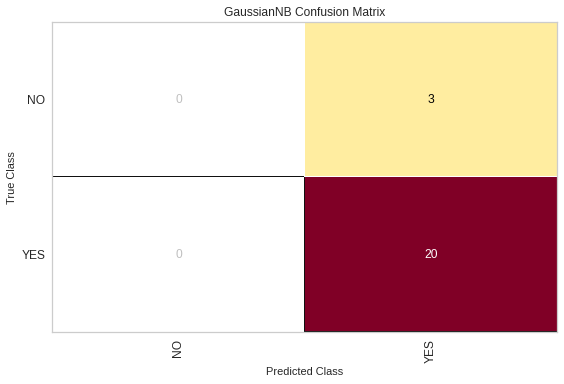

In [133]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(model, classes=['NO','YES'])
cm.fit(x_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(x_test, y_test)
cm.show()


# Applying K Nearest Neighbor

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [139]:
knn = KNeighborsClassifier()

In [140]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [141]:
y_pred_train = knn.predict(x_train)

In [142]:
y_pred_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [143]:
y_pred_test = knn.predict(x_test)

In [144]:
y_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [145]:
accuracy_score(y_pred_train, y_train)

0.8679245283018868

In [146]:
accuracy_score(y_pred_test, y_test)

0.8695652173913043

In [150]:
precision_score(y_pred_train, y_train, average=None)

array([0., 1.])

In [151]:
precision_score(y_pred_test, y_test, average=None)

array([0., 1.])

In [152]:
precision_score(y_pred_test, y_test, average='macro')

0.5

In [153]:
precision_score(y_pred_test, y_test, average='weighted')

1.0

In [154]:
confusion_matrix(y_pred_train, y_train)

array([[ 0,  0],
       [ 7, 46]])

In [155]:
confusion_matrix(y_pred_test, y_test)

array([[ 0,  0],
       [ 3, 20]])

In [156]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93        53

    accuracy                           0.87        53
   macro avg       0.50      0.43      0.46        53
weighted avg       1.00      0.87      0.93        53



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93        23

    accuracy                           0.87        23
   macro avg       0.50      0.43      0.47        23
weighted avg       1.00      0.87      0.93        23



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
def knn_model(k, X_train, X_test, Y_train, Y_test, weights='uniform', metric='minkowski'):
    # weights: uniform, distance ; metric: minkowski, euclidean, manhattan, cosine
    knn = KNeighborsClassifier(n_neighbors = k, weights=weights, metric=metric)
    print("K :", k)
    print("Weights :", weights)
    print("Metric : ", metric)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    print("\nConfusion Matrix :\n", confusion_matrix(Y_test, Y_pred))
    print("\nAccuracy Score : ", accuracy_score(Y_test, Y_pred))
    print("\nClassification Report :\n", classification_report(Y_test, Y_pred))

In [159]:
for k in range (1, 19, 2) :
  knn_model(k, x_train, x_test, y_train, y_test)

K : 1
Weights : uniform
Metric :  minkowski

Confusion Matrix :
 [[ 0  3]
 [ 3 17]]

Accuracy Score :  0.7391304347826086

Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.85      0.85      0.85        20

    accuracy                           0.74        23
   macro avg       0.42      0.42      0.42        23
weighted avg       0.74      0.74      0.74        23

K : 3
Weights : uniform
Metric :  minkowski

Confusion Matrix :
 [[ 0  3]
 [ 2 18]]

Accuracy Score :  0.782608695652174

Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      0.90      0.88        20

    accuracy                           0.78        23
   macro avg       0.43      0.45      0.44        23
weighted avg       0.75      0.78      0.76        23

K : 5
Weights : uniform
Metric :  minkowski

Confus

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat